In [19]:
import sys
sys.path.append('..')

import json
import torch
from pathlib import Path
import numpy as np
from sklearn.metrics import confusion_matrix

#import pytorch_lightning as pl
from multiprocessing import cpu_count
from libraries.lightningDMBACNN import ImageFolderLightningDataModule, WhoiDataModule, ZooscanDataModule, LenslessDataModule, ZooLakeDataModule#from libraries.helper_functions import class_histogram, sample_images, imshow
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import seaborn as sns
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassRecall, MulticlassPrecision

#torch.cuda.empty_cache()


NAME_OF_EXPERIMENT = 'basic_BCNN_Zooscan_v1'#'basic_BCNN_Zooscan_v1'#'test_HBilinear_Zooscan_v1'
#'test_hierar_Zooscan_v4'#'test_BACNN_Zooscan_v2'#'test_hierar_Zooscan_v5_storage'#'CustomNEW_Zooscan_v1'

WORKING_DIR = Path.cwd()
DATA_DIR =  Path.cwd().parent / 'data/Zooscan_hierarchical_imagefolder'

EXPERIMENT_DIR = WORKING_DIR / f'experiments_folder/{NAME_OF_EXPERIMENT}'
MODELS_DIR = EXPERIMENT_DIR / 'models'

RESULTS_DIR = EXPERIMENT_DIR / 'results'

MEAN_STD_PATH = Path.cwd() / 'libraries/saved_mean_std/Zooscan_mean_std_224'


In [7]:
NUM_CLASSES = [[2, 13, 93], [2, 4, 12, 9, 81]]

In [8]:
datamodule = ImageFolderLightningDataModule(
                                                        data_dir=DATA_DIR,
                                                        mean_std_path = MEAN_STD_PATH,
                                                        image_size = 224,
                                                        batch_size = 8,
                                                        split_seed = 42,
                                                        num_workers=cpu_count(), 
                                                        sampler = True,                                             # Use True for Weighted Sampler or False to not use any
                                                        pin_memory = True,   # Default is False
                                                    )

datamodule.setup()

num_classes = datamodule.num_classes

In [9]:
datamodule.dataset.classes[:5]

['IRRELEVANT___ARTEFACT___artefact',
 'IRRELEVANT___ARTEFACT___badfocus__Copepoda',
 'IRRELEVANT___ARTEFACT___badfocus__artefact',
 'IRRELEVANT___ARTEFACT___bubble',
 'IRRELEVANT___DETRITUS___detritus']

# Calculate metrics and confusion matrix

In [10]:
def calculate_metrics(result_dir, nb_classes):
    y_true_test = torch.load(result_dir / 'c_true_test.pt', map_location=torch.device('cpu'))
    y_pred_1 = torch.load(result_dir / 'c_pred_1_test.pt', map_location=torch.device('cpu'))
    y_pred_2 = torch.load(result_dir / 'c_pred_2_test.pt', map_location=torch.device('cpu'))
    y_pred_3 = torch.load(result_dir / 'c_pred_3_test.pt', map_location=torch.device('cpu'))

    print(f'Model has 3 different layers')
    mcA_1 = MulticlassAccuracy(num_classes=nb_classes[0], average='macro')
    mcF1_1 = MulticlassF1Score(num_classes=nb_classes[0], average='weighted')
    mcR_1 = MulticlassRecall(num_classes=nb_classes[0], average='macro')
    mcP_1 = MulticlassPrecision(num_classes=nb_classes[0], average='macro')

    mcA_2 = MulticlassAccuracy(num_classes=nb_classes[1], average='macro')
    mcF1_2 = MulticlassF1Score(num_classes=nb_classes[1], average='weighted')
    mcR_2 = MulticlassRecall(num_classes=nb_classes[1], average='macro')
    mcP_2 = MulticlassPrecision(num_classes=nb_classes[1], average='macro')

    mcA_3 = MulticlassAccuracy(num_classes=nb_classes[2], average='macro')
    mcF1_3 = MulticlassF1Score(num_classes=nb_classes[2], average='weighted')
    mcR_3 = MulticlassRecall(num_classes=nb_classes[2], average='macro')
    mcP_3 = MulticlassPrecision(num_classes=nb_classes[2], average='macro')
    print('Metrics for level 1:')
    print(f'\tTest Accuracy is: \t{mcA_1(y_pred_1, y_true_test[:, 0])}')
    print(f'\tTest F1 Score is: \t{mcF1_1(y_pred_1, y_true_test[:, 0])}')
    print(f'\tTest Precision is: \t{mcP_1(y_pred_1, y_true_test[:, 0])}')
    print(f'\tTest Recall is: \t{mcR_1(y_pred_1, y_true_test[:, 0])}')

    print('Metrics for level 2:')
    print(f'\tTest Accuracy is: \t{mcA_2(y_pred_2, y_true_test[:, 1])}')
    print(f'\tTest F1 Score is: \t{mcF1_2(y_pred_2, y_true_test[:, 1])}')
    print(f'\tTest Precision is: \t{mcP_2(y_pred_2, y_true_test[:, 1])}')
    print(f'\tTest Recall is: \t{mcR_2(y_pred_2, y_true_test[:, 1])}')

    print('Metrics for level 3:')
    print(f'\tTest Accuracy is: \t{mcA_3(y_pred_3, y_true_test[:, 2])}')
    print(f'\tTest F1 Score is: \t{mcF1_3(y_pred_3, y_true_test[:, 2])}')
    print(f'\tTest Precision is: \t{mcP_3(y_pred_3, y_true_test[:, 2])}')
    print(f'\tTest Recall is: \t{mcR_3(y_pred_3, y_true_test[:, 2])}')

In [ ]:
def calculate_metrics_subset(result_dir, subset):
    y_true_test = torch.load(result_dir / 'c_true_test.pt', map_location=torch.device('cpu'))
    y_pred_1 = torch.load(result_dir / 'c_pred_1_test.pt', map_location=torch.device('cpu'))
    y_pred_2 = torch.load(result_dir / 'c_pred_2_test.pt', map_location=torch.device('cpu'))
    y_pred_3 = torch.load(result_dir / 'c_pred_3_test.pt', map_location=torch.device('cpu'))
    
    if len(y_pred_1.size()) == 2:
        y_pred_1 = torch.argmax(y_pred_1, dim=1)
        y_pred_2 = torch.argmax(y_pred_2, dim=1)
        y_pred_3 = torch.argmax(y_pred_3, dim=1)
        
    indices = []
    if subset == 'irrelevant':
        compare = 0
    else:
        compare = 1

    for i in range(len(y_pred_1)):
        if y_pred_1[i] == compare and int(y_true_test[i, 0]) == compare:
            indices.append(i)
            if subset == 'irrelevant':
                nb_classes = [2, 4, 12]
                integers=[0, 0]
                y_pred_2[i] = min(y_pred_2[i], 3)
                y_pred_3[i] = min(y_pred_3[i], 11)
            else:
                nb_classes = [2, 9, 81]
                integers=[4, 12]
                y_pred_2[i] = max(y_pred_2[i], 4)
                y_pred_3[i] = max(y_pred_3[i], 12)
    print(f'The size of the sample subset is:\t {len(indices)}')

    print(f'Model has 3 different layers')
    mcA_1 = MulticlassAccuracy(num_classes=nb_classes[0], average='macro')
    mcF1_1 = MulticlassF1Score(num_classes=nb_classes[0], average='weighted')
    mcR_1 = MulticlassRecall(num_classes=nb_classes[0], average='macro')
    mcP_1 = MulticlassPrecision(num_classes=nb_classes[0], average='macro')

    mcA_2 = MulticlassAccuracy(num_classes=nb_classes[1], average='macro')
    mcF1_2 = MulticlassF1Score(num_classes=nb_classes[1], average='weighted')
    mcR_2 = MulticlassRecall(num_classes=nb_classes[1], average='macro')
    mcP_2 = MulticlassPrecision(num_classes=nb_classes[1], average='macro')

    mcA_3 = MulticlassAccuracy(num_classes=nb_classes[2], average='macro')
    mcF1_3 = MulticlassF1Score(num_classes=nb_classes[2], average='weighted')
    mcR_3 = MulticlassRecall(num_classes=nb_classes[2], average='macro')
    mcP_3 = MulticlassPrecision(num_classes=nb_classes[2], average='macro')
    print('Metrics for level 1:')
    print(f'\tTest Accuracy is: \t{mcA_1(y_pred_1[indices], y_true_test[indices, 0])}')
    print(f'\tTest F1 Score is: \t{mcF1_1(y_pred_1[indices], y_true_test[indices, 0])}')
    print(f'\tTest Precision is: \t{mcP_1(y_pred_1[indices], y_true_test[indices, 0])}')
    print(f'\tTest Recall is: \t{mcR_1(y_pred_1[indices], y_true_test[indices, 0])}')

    print('Metrics for level 2:')
    print(f'\tTest Accuracy is: \t{mcA_2(y_pred_2[indices] - integers[0], y_true_test[indices, 1] - integers[0])}')
    print(f'\tTest F1 Score is: \t{mcF1_2(y_pred_2[indices] - integers[0], y_true_test[indices, 1] - integers[0])}')
    print(f'\tTest Precision is: \t{mcP_2(y_pred_2[indices] - integers[0], y_true_test[indices, 1] - integers[0])}')
    print(f'\tTest Recall is: \t{mcR_2(y_pred_2[indices] - integers[0], y_true_test[indices, 1] - integers[0])}')

    print('Metrics for level 3:')
    print(f'\tTest Accuracy is: \t{mcA_3(y_pred_3[indices] - integers[1], y_true_test[indices, 2] - integers[1])}')
    print(f'\tTest F1 Score is: \t{mcF1_3(y_pred_3[indices] - integers[1], y_true_test[indices, 2] - integers[1])}')
    print(f'\tTest Precision is: \t{mcP_3(y_pred_3[indices] - integers[1], y_true_test[indices, 2] - integers[1])}')
    print(f'\tTest Recall is: \t{mcR_3(y_pred_3[indices] - integers[1], y_true_test[indices, 2] - integers[1])}')

In [14]:
calculate_metrics(RESULTS_DIR, NUM_CLASSES[0])

Model has 3 different layers
Metrics for level 1:
	Test Accuracy is: 	0.9724181890487671
	Test F1 Score is: 	0.9724745154380798
	Test Precision is: 	0.9724994897842407
	Test Recall is: 	0.9724181890487671
Metrics for level 2:
	Test Accuracy is: 	0.8910173177719116
	Test F1 Score is: 	0.9404957294464111
	Test Precision is: 	0.9312595129013062
	Test Recall is: 	0.8910173177719116
Metrics for level 3:
	Test Accuracy is: 	0.8148709535598755
	Test F1 Score is: 	0.9013187885284424
	Test Precision is: 	0.8635057806968689
	Test Recall is: 	0.8148709535598755


In [ ]:
calculate_metrics_subset(RESULTS_DIR, 'irrelevant')

In [ ]:
calculate_metrics_subset(RESULTS_DIR, 'relevant')

In [22]:
def confusion_report(pred_label, true_label, annot=False, figsize=(8,6), save_fig=False, categories=None):
    num_classes = len(categories)
    confu = confusion_matrix(true_label, pred_label, labels=np.arange(num_classes), normalize='true')
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(confu, annot=annot, vmin=0.0, vmax=1.0,
                     xticklabels=categories, yticklabels=categories
                    )
    ax.set_title(f"Confusion Matrix of experiment {NAME_OF_EXPERIMENT}")
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    if save_fig:
        plt.savefig(RESULTS_DIR / f'Confusion_Matrix_{NAME_OF_EXPERIMENT}.png')

    plt.show()

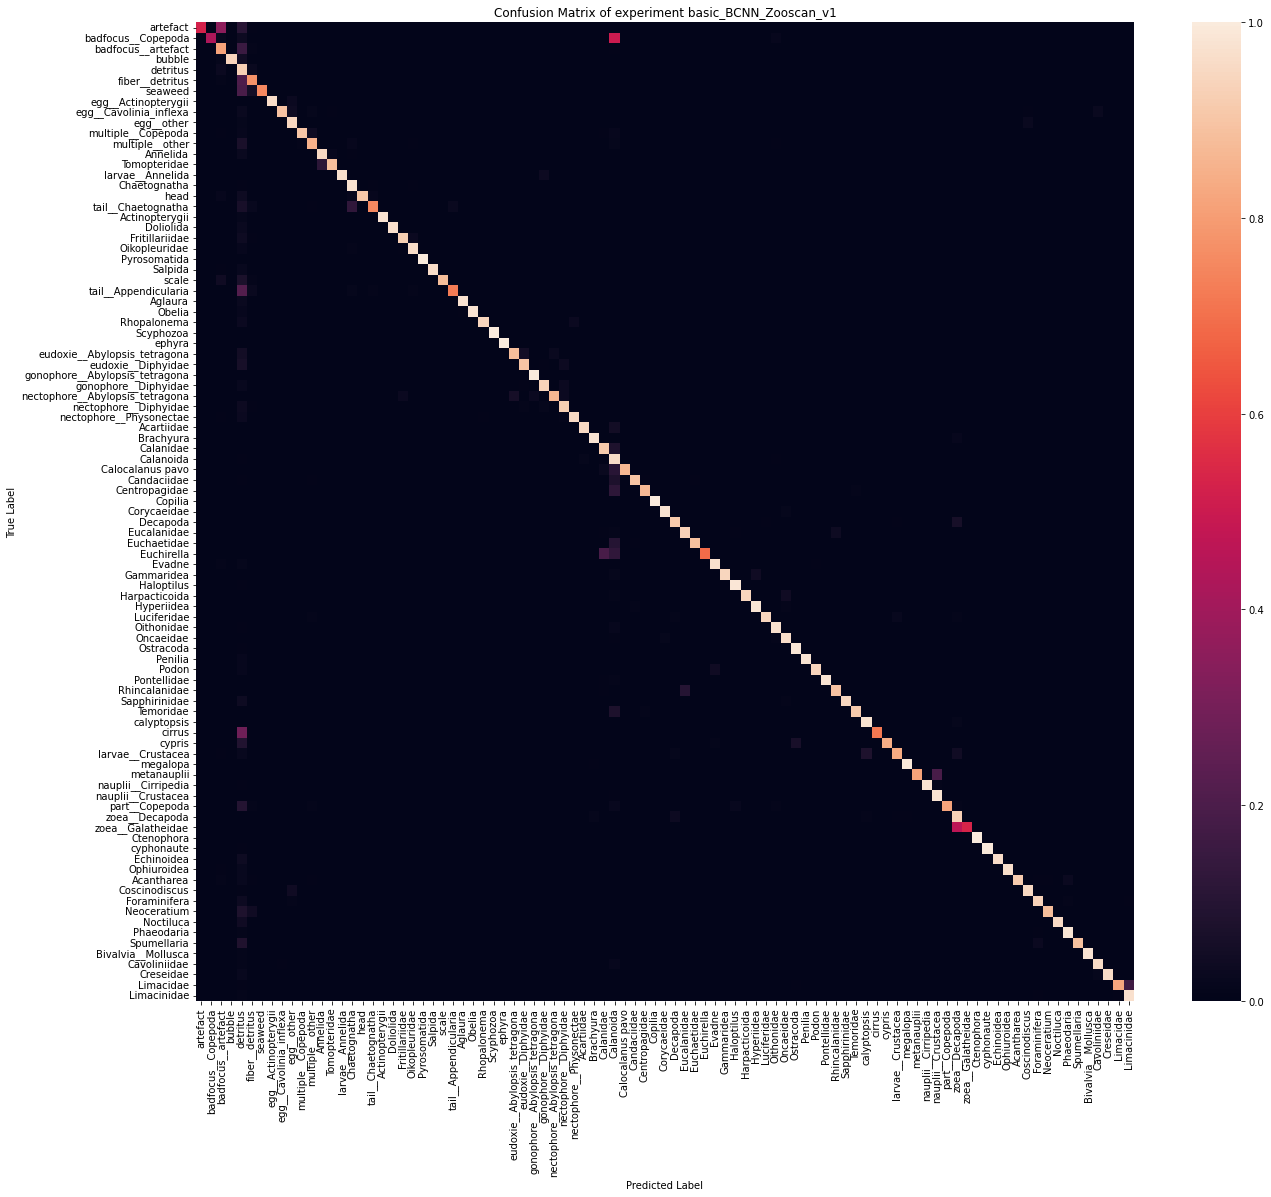

In [23]:
# Create the confusion matrix
classes_names = datamodule.dataset.classes
clean_names = [name.split('___')[2] for name in classes_names]

y_pred_3 = torch.load(RESULTS_DIR / 'c_pred_3_test.pt', map_location=torch.device('cpu'))
if len(y_pred_3.size()) == 2: y_pred_3 = torch.argmax(y_pred_3, dim=1)
y_true_test = torch.load(RESULTS_DIR / 'c_true_test.pt', map_location=torch.device('cpu'))


confusion_report(y_pred_3, y_true_test[:, 2], figsize=(21,18), annot=False, save_fig=False, categories=clean_names)

# Saving individual class accuracy

In [ ]:
mcAconfu = MulticlassAccuracy(num_classes=len(clean_names), average=None)
results = mcAconfu(y_pred_3, y_true_test[:, 2])

In [106]:
import pandas as pd

data = {'classes_names': clean_names, f'results_{NAME_OF_EXPERIMENT}': results}
df = pd.DataFrame(data)

df.to_csv(RESULTS_DIR / f'Results_{NAME_OF_EXPERIMENT}.csv', sep='\t')

# Coherence

In [37]:
def calculate_coherence(result_dir):
    y_true_test = torch.load(result_dir / 'c_true_test.pt', map_location=torch.device('cpu'))
    y_pred_1 = torch.load(result_dir / 'c_pred_1_test.pt', map_location=torch.device('cpu'))
    y_pred_2 = torch.load(result_dir / 'c_pred_2_test.pt', map_location=torch.device('cpu'))
    y_pred_3 = torch.load(result_dir / 'c_pred_3_test.pt', map_location=torch.device('cpu'))
    
    if len(y_pred_1.size()) == 2:
        y_pred_1 = torch.argmax(y_pred_1, dim=1)
        y_pred_2 = torch.argmax(y_pred_2, dim=1)
        y_pred_3 = torch.argmax(y_pred_3, dim=1)
    
    length = len(y_pred_1)
    
    indices_irrelevant = []
    indices_relevant = []
    for i in range(length):
        if y_true_test[i, 0] == 1.:
            indices_relevant.append(i)
        else: #if y_true_test[i, 0] == 1.
            indices_irrelevant.append(i)
            
    len_irrelevant = len(indices_irrelevant)
    len_relevant = len(indices_relevant)
    print(f'The size of the irrelevant subset is:\t {len_irrelevant}')
    print(f'The size of the relevant subset is:\t {len_relevant}')
        
    acc_coherence = 0
    acc_coherence_relevant = 0
    acc_coherence_irrelevant = 0
    
    for i in indices_irrelevant:
        if (y_pred_1[i] == int(y_true_test[i, 0])) and (y_pred_2[i] == int(y_true_test[i, 1])) and (y_pred_3[i] == int(y_true_test[i, 2])):
            acc_coherence_irrelevant+=1
    for i in indices_relevant:
        if (y_pred_1[i] == int(y_true_test[i, 0])) and (y_pred_2[i] == int(y_true_test[i, 1])) and (y_pred_3[i] == int(y_true_test[i, 2])):
            acc_coherence_relevant+=1
    
    acc_coherence = acc_coherence_relevant + acc_coherence_irrelevant

    print(f'\nCoherence Accuracy for all samples is:\t\t{acc_coherence/length}')
    print(f'Coherence Accuracy for relevant samples is:\t{acc_coherence_relevant/len_relevant}')
    print(f'Coherence Accuracy for irrelevant samples is:\t{acc_coherence_irrelevant/len_irrelevant}')



In [38]:
RESULTS_DIR = Path.cwd()/'experiments_folder/test_hierar_Zooscan_v6_storage/results'

#test_BACNN_Zooscan_v2
#test_HBilinear_Zooscan_v1
#basic_BCNN_Zooscan_v1
#test_hierar_Zooscan_v5_storage

In [40]:
calculate_coherence(RESULTS_DIR)

The size of the irrelevant subset is:	 146903
The size of the relevant subset is:	 139753

Coherence Accuracy for all samples is:		0.8991508986380888
Coherence Accuracy for relevant samples is:	0.9323735447539587
Coherence Accuracy for irrelevant samples is:	0.8675452509479044
